In [1]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from generate_data import make_toy_data
import sys
import os

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("GRAIMatter")))
sys.path.append(ROOT_DIR)

# Decision tree example with toy data
To illustrate the concept of risk and safe wrappers, this example uses:
- a simplified dataset
- a decision tree classifier

### Please note this is only so we can fit the illustrations nicely on a screen!

## We'll start by  making our 'toy' data, and showing what the first five rows look like

In [2]:
toy_df = make_toy_data([5, 50, 1],seed = 4009)
toy_df.head()
feature_names = ('age','smoker','resting_hr','weight','employed','label')
labels_present = toy_df['label'].unique()
print(f'The different labels present are {labels_present} and the first five rows are:')
toy_df.head()

The different labels present are [0 1 2] and the first five rows are:


,age,smoker,resting_hr,weight,employed,label
0,47,0,72,80,0,0
1,38,1,80,83,0,0
2,46,1,71,69,0,0
3,33,1,71,65,0,0
4,46,0,75,73,0,0


## Now imagine our researcher decides to investigate what factors lead to disease risk,
- And they are not a ML expert 
- so they split their data into features (X) and labels (y) to be predicted
- and use the default algorithm settings to learn a decision tree

In [3]:
#get data into rightformat
train_y = toy_df['label']
train_X = toy_df.drop('label', axis=1)

tree = DecisionTreeClassifier()
#Most ML libraries includer a fit() and a score() method
tree.fit(train_X, train_y)
accuracy = tree.score(train_X,train_y)
print( f'Training set accuracy = {100*accuracy}%')


Training set accuracy = 100.0%


## Great so far, ...  but what does this tree look like?

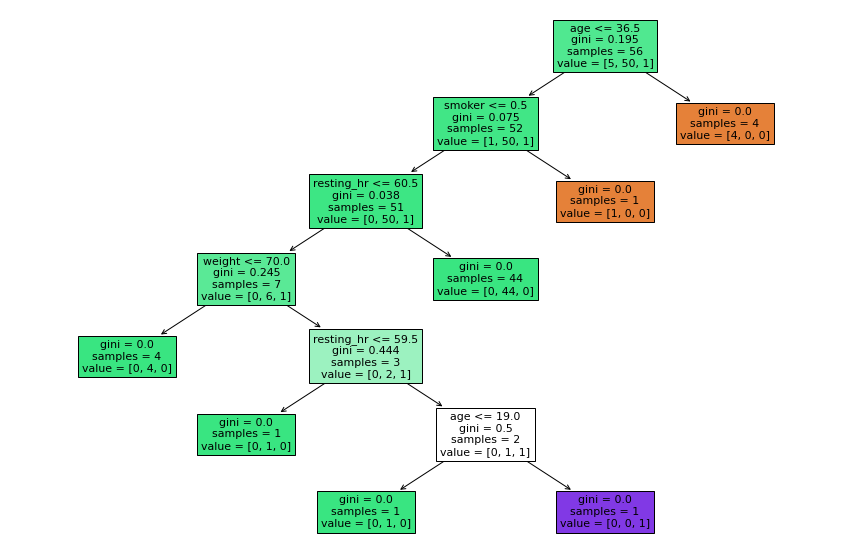

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
output = plot_tree(tree, filled=True, ax=ax, fontsize=11,feature_names = feature_names)

## What's the problem here?
There's exactly one person with 
<div>

  <div style="float:left;width:25%">
      <h3>Label 2 (purple box)</h3>
      <ul>
          <li>19 &lt; age &lt; 36.5 </li>
          <li> smoker = 0 </li>
          <li>  59.5 &lt; resting heart rate &lt; 60.5</li>
          <li>70 &lt; weight </li>
      </ul>
  </div> 
  <div style="float:left;width:10%">
      <p>.</p>
  </div>
  <div style="float:left;width:25%">
          <h3> Label 1 (green box)</h3>
      <ul>
          <li> age &lt; 19 </li>
          <li> smoker = 0 </li>
          <li>  59.5 &lt; resting heart rate &lt; 60.5</li>
          <li>70 &lt; weight </li>
      </ul>
  </div>
  </div> 
  <div style="float:left;width:10%">
      <p>.</p>
  </div>
  <div style="float:left;width:25%">
          <h3> Label 2 (brown box)</h3>
      <ul>
          <li> age &lt; 36.5 </li>
          <li> smoker = 0 </li>
      </ul>
  </div>
<br style="clear:left;"/>     
</div>

- and even if that is not enough to identify someone uniquely, 
- it's not hard to imagine how this could be even more disclosive 
- if we didn't restrict the tree to fit on one slide ... 

## 'Attacking' models can be automated 

### Diligent user realises problem, and changes their code to enforce at least *k* samples in each leaf
- they might assume this is equivalent to  *k*-anonymity
- how should they choose *k*?

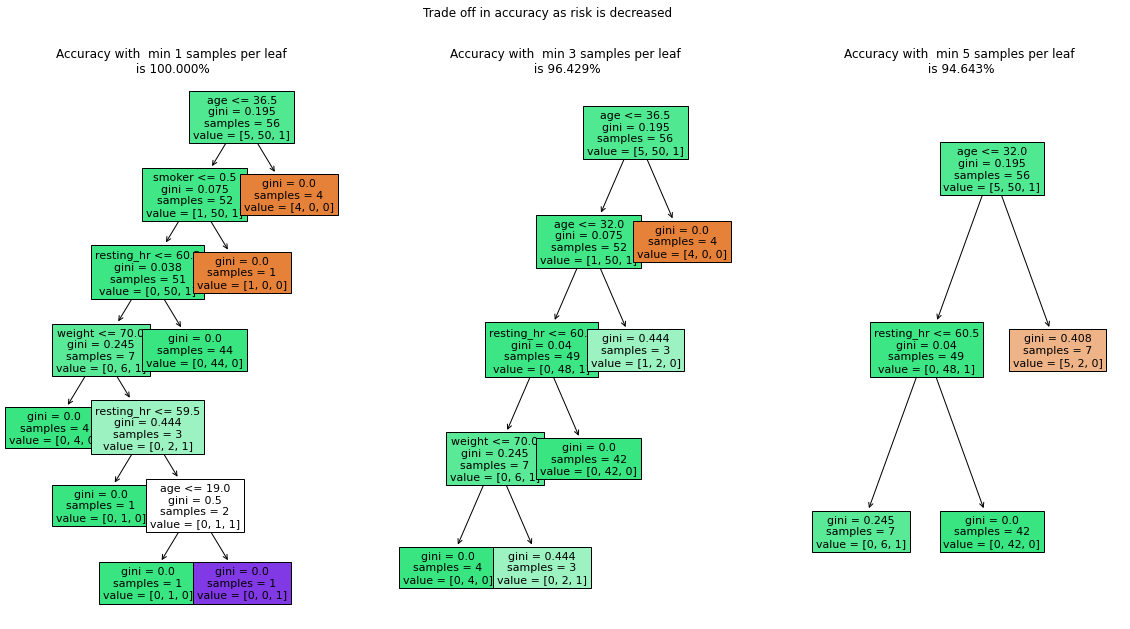

In [5]:

fig2, ax2 = plt.subplots(1, 3, figsize=(20, 10))
fig2.suptitle('Trade off in accuracy as risk is decreased')
for k in (1,3,5):
    column=int((k-1)/2)
    manualDT = DecisionTreeClassifier(min_samples_leaf=k, random_state=1)
    manualDT.fit(train_X, train_y)
    output = plot_tree(manualDT, filled=True, ax=ax2[column], fontsize=11,feature_names = feature_names)
    ax2[column].set_title(f'Accuracy with  min {k} samples per leaf\n is {100*manualDT.score(train_X,train_y):.3f}%')

# The basic idea of the safe wrappers we are going to introduce
1. TREs (not researchers) make decisions about safety-accuracy trade-off based on risk appetite  
   using hyper-parameters <=> risk analysis we're doing in GRAIMatter
2. TREs make available wrapper versions of  algorithms that add:  
   - Code to set hyper-parameters to safe values  
   - A 'requestRelease' method that generates a report for the TRE staff


In [6]:

from safemodel.classifiers import SafeDecisionTreeClassifier

safeDT = SafeDecisionTreeClassifier(min_samples_leaf=1)
safeDT.fit(train_X, train_y)

print( f'Training set accuracy = {100*safeDT.score(train_X,train_y)}%')

#This is the new function
safeDT.request_release('mysavefile.pkl')

print('This is the output report:')
%cat "j4-smith_checkfile.json"


- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Changed parameter min_samples_leaf = 5.

Training set accuracy = 94.64285714285714%
This is the output report:
{
    "researcher": "j4-smith",
    "model_type": "DecisionTreeClassifier",
    "model_save_file": "mysavefile.pkl",
    "details": "Model parameters are within recommended ranges.\n",
    "recommendation": "Run file mysavefile.pkl through next step of checking procedure"
}

Not for presentation - this is how i found that seed to use

In [ ]:
pathlength = 0
bestsofar=0
for attempts in range (20000):
    seed=attempts*10
    toy_df = make_toy_data([50, 250, 1],seed)
    train_y = toy_df['label']
    train_X = toy_df.drop('label', axis=1)
    tree = DecisionTreeClassifier(max_depth= 5)
    tree.fit(train_X, train_y)
    paths = tree.decision_path(train_X)
    complexity =  paths[-1].sum()
    if(complexity>bestsofar):
        bestsofar = complexity
        print(f'new best with complexity {complexity} for seed {attempts}')
        plot_tree(tree, filled=True,  fontsize=10,feature_names = feature_names)
        fig = plt.gcf()
        fig.set_size_inches(15,15)
    if(complexity>=9):
        break

 19 < age < 36.5
 smoker = 0
 59.5 < resting heart rate <= 60.5
 70 < weight